Window functions give you information that you can't get with a GROUP BY, but they don't fundamentally change the structure of your result. What if you want to transform ranking data from a vertical to a horizontal structure, making it easier to scan?

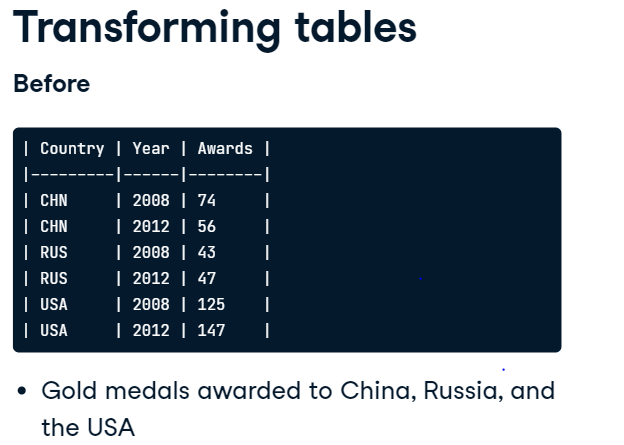


Pivoting transforms a table by making columns out of the unique values of one of its columns. The before table here represents the gold medals awarded to these three countries in the 2008 and 2012 Olympics. Once this table is pivoted by year, that column's unique values, 2008 and 2012, become columns in the after table. The values are automatically placed in the reshaped table. In general, pivoted tables are easier to scan, especially if pivoted by a chronologically ordered column.

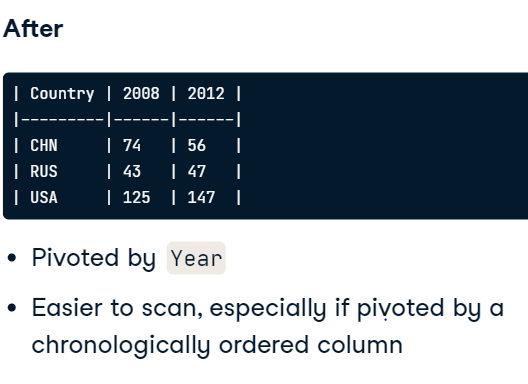

How do you do this in SQL, though? Enter CROSSTAB. CROSSTAB allows you to pivot a table by a certain column. You'll need to use the CREATE EXTENSION statement before using CROSSTAB. CREATE EXTENSION makes extra functions in an extension available for use. The tablefunc extension contains the CROSSTAB function. After that, place your source query in between the two dollar sign pairs. 

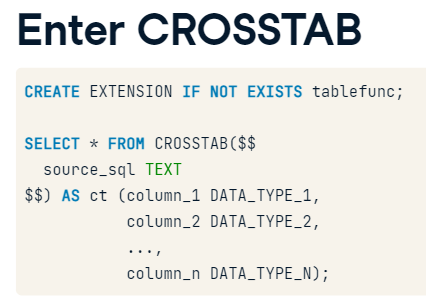

Finally, in the parentheses after ct, write the column names and types of your new pivoted table. The column names are the unpivoted column and the unique values of the pivoted column. Let's see this in action.

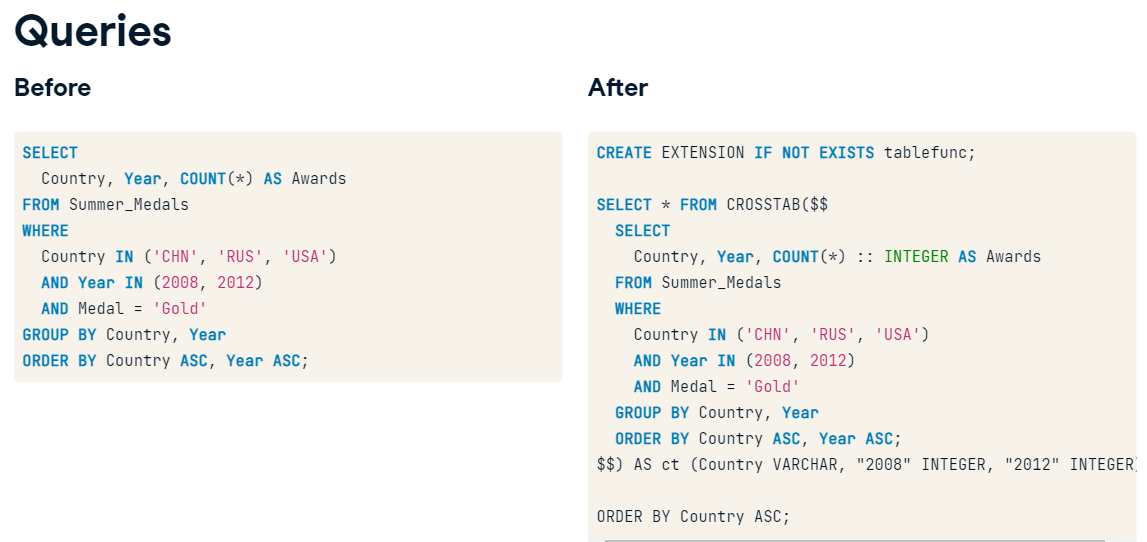

The before query generates the before table from two slides ago. After the CREATE EXTENSION statement, the before query is placed entirely between the two dollar sign pairs. The table is pivoted by Year, and the table's values are in the Awards column, so the columns are the unpivoted column (Country) and the unique values in the Year column (2008 and 2012). This query generates the after table from two slides ago.

How would you use pivoting with window functions? Let's take an example. This query should be pretty familiar. The CTE counts the gold medals awarded to three countries in the 2004, 2008, and 2012 Olympics. Then, each country's rank is calculated according to who won the the most gold medals in each Olympic games. Cast RANK to integer to determine the column type of the pivoted columns.

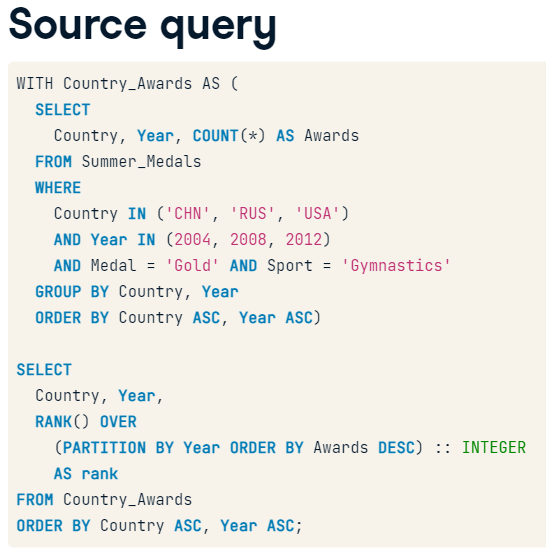

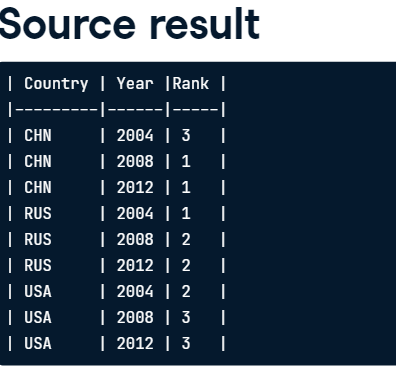

This is the result. Notice that the rankings reset after each Olympic games. Wouldn't this be easier to read if it were pivoted by year?

Replace the ellipsis with the source query from two slides back. Then, in the parentheses after ct, list the pivoted table's column names and types. Since you're pivoting by year, and the values are in Awards, the columns are Country (the unpivoted column) and the unique values in Year (2004, 2008, and 2012). Make sure to list the unique values in correct order.

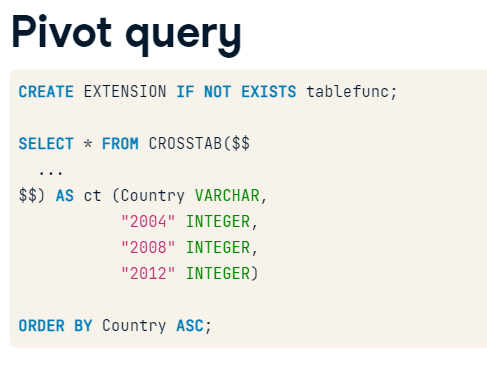

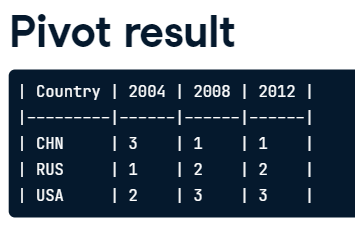

This is the result. The rankings are easily scannable by country and year now.

Pivoting is useful when preparing data for visualization and reporting. Let's practice reshaping tables in the following exercises.


#### A basic pivot
You have the following table of Pole Vault gold medalist countries by gender in 2008 and 2012.

| Gender | Year | Country |
|--------|------|---------|
| Men    | 2008 | AUS     |
| Men    | 2012 | FRA     |
| Women  | 2008 | RUS     |
| Women  | 2012 | USA     |

Pivot it by Year to get the following reshaped, cleaner table.

| Gender | 2008 | 2012 |
|--------|------|------|
| Men    | AUS  | FRA  |
| Women  | RUS  | USA  |


- Create the correct extension.
- Fill in the column names of the pivoted table.


```sql
-- Create the correct extention to enable CROSSTAB
CREATE EXTENSION IF NOT EXISTS tablefunc;

SELECT * FROM CROSSTAB($$
  SELECT
    Gender, Year, Country
  FROM Summer_Medals
  WHERE
    Year IN (2008, 2012)
    AND Medal = 'Gold'
    AND Event = 'Pole Vault'
  ORDER By Gender ASC, Year ASC;
-- Fill in the correct column names for the pivoted table
$$) AS ct (Gender VARCHAR,
           Year VARCHAR,
           Country VARCHAR)

ORDER BY Gender ASC;
```
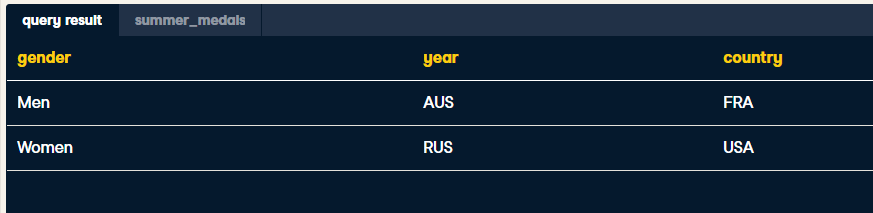

#### Pivoting with ranking
You want to produce an easy scannable table of the rankings of the three most populous EU countries by how many gold medals they've earned in the 2004 through 2012 Olympic games. The table needs to be in this format:


| Country | 2004 | 2008 | 2012 |
|---------|------|------|------|
| FRA     | ...  | ...  | ...  |
| GBR     | ...  | ...  | ...  |
| GER     | ...  | ...  | ...  |

You'll need to count the gold medals each country has earned, produce the ranks of each country by medals earned, then pivot the table to this shape.

- Count the gold medals that France (FRA), the UK (GBR), and Germany (GER) have earned per country and year.

```sql
-- Count the gold medals per country and year
SELECT
  country,
  year,
  COUNT(*) AS Awards
FROM Summer_Medals
WHERE
  Country IN ('FRA', 'GBR', 'GER')
  AND Year IN (2004, 2008, 2012)
  AND Medal = 'Gold'
GROUP BY Country, Year
ORDER BY Country ASC, Year ASC
```
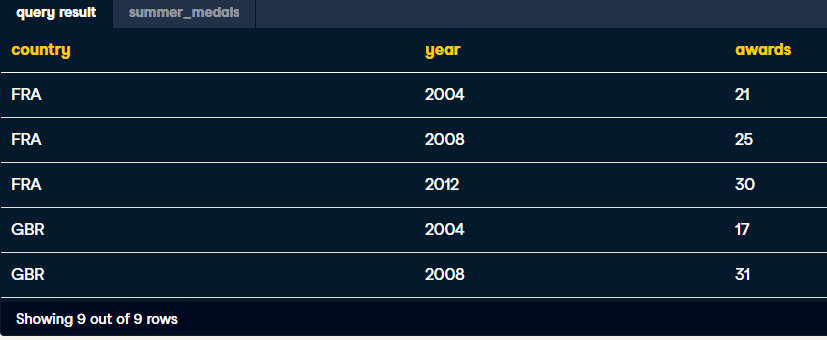

- Select the country and year columns, then rank the three countries by how many gold medals they earned per year.

```sql
WITH Country_Awards AS (
  SELECT
    Country,
    Year,
    COUNT(*) AS Awards
  FROM Summer_Medals
  WHERE
    Country IN ('FRA', 'GBR', 'GER')
    AND Year IN (2004, 2008, 2012)
    AND Medal = 'Gold'
  GROUP BY Country, Year)

SELECT
  -- Select Country and Year
  Country,
  Year,
  -- Rank by gold medals earned per year
  RANK() OVER (PARTITION BY Year ORDER BY Awards) :: INTEGER AS rank
FROM Country_Awards
ORDER BY Country ASC, Year ASC;
```

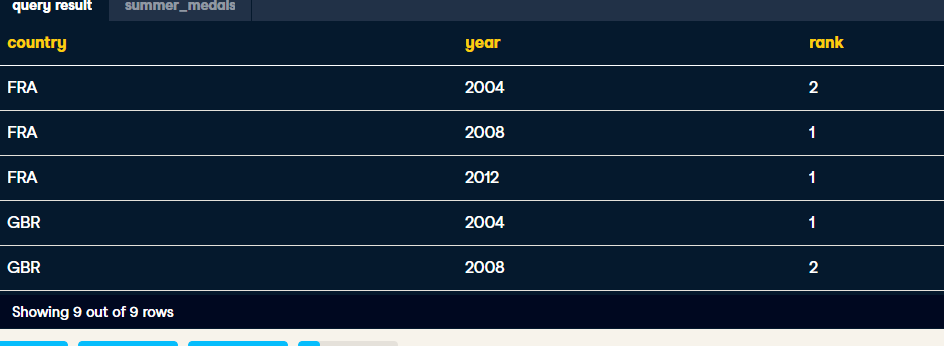

- Pivot the query's results by Year by filling in the new table's correct column names.

```sql
CREATE EXTENSION IF NOT EXISTS tablefunc;

SELECT * FROM CROSSTAB($$
  WITH Country_Awards AS (
    SELECT
      Country,
      Year,
      COUNT(*) AS Awards
    FROM Summer_Medals
    WHERE
      Country IN ('FRA', 'GBR', 'GER')
      AND Year IN (2004, 2008, 2012)
      AND Medal = 'Gold'
    GROUP BY Country, Year)

  SELECT
    Country,
    Year,
    RANK() OVER
      (PARTITION BY Year
       ORDER BY Awards DESC) :: INTEGER AS rank
  FROM Country_Awards
  ORDER BY Country ASC, Year ASC;
-- Fill in the correct column names for the pivoted table
$$) AS ct (Country VARCHAR,
           "2004" INTEGER,
           "2008" INTEGER,
           "2012" INTEGER)

Order by Country ASC;
```
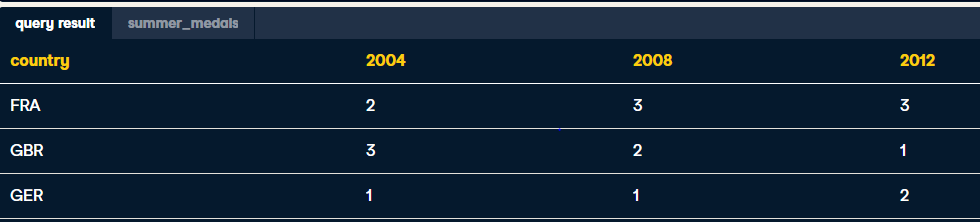
